# Scotland’s Monthly Birth-Rate Forecasting

## Import Libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [ ]:
df = pd.read_excel('dataset.xlsx')
df.head()

## Data Preprocessing

In [55]:
df.columns = ['Year', 'Month', 'NHS_Board', 'Births']

In [56]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  

df_filtered = df[(df['Year'] >= 1998) & (df['Year'] <= 2022)]

In [57]:
df_scotland = df_filtered[df_filtered['NHS_Board'] == 'Scotland']

In [58]:
df_scotland.reset_index(drop=True, inplace=True)

In [66]:
df_scotland.info()
df_scotland.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Year       300 non-null    int64         
 1   Month      300 non-null    object        
 2   NHS_Board  300 non-null    object        
 3   Births     300 non-null    int64         
 4   Date       300 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.8+ KB


,Year,Births,Date
count,300.000000,300.000000,300
mean,2010.000000,4519.970000,2010-06-16 13:55:12
min,1998.000000,18.000000,1998-01-01 00:00:00
25%,2004.000000,4254.000000,2004-03-24 06:00:00
50%,2010.000000,4568.500000,2010-06-16 00:00:00
75%,2016.000000,4834.750000,2016-09-08 12:00:00
max,2022.000000,9233.000000,2022-12-01 00:00:00
std,7.223151,677.338221,NaN


In [67]:
df_scotland.isnull().sum()

Year         0
Month        0
NHS_Board    0
Births       0
Date         0
dtype: int64

In [ ]:
df_scotland['Year'] = df_scotland['Year'].astype(int)

df_scotland['Date'] = pd.to_datetime(df_scotland['Month'] + ' ' + df_scotland['Year'].astype(str), format='%B %Y')

In [65]:
df_scotland['Births'] = df_scotland['Births'].astype(int)

In [68]:
df = df_scotland.copy()

## Exploratory Data Analysis

**Full Monthly Birth Trend (1998–2022)**

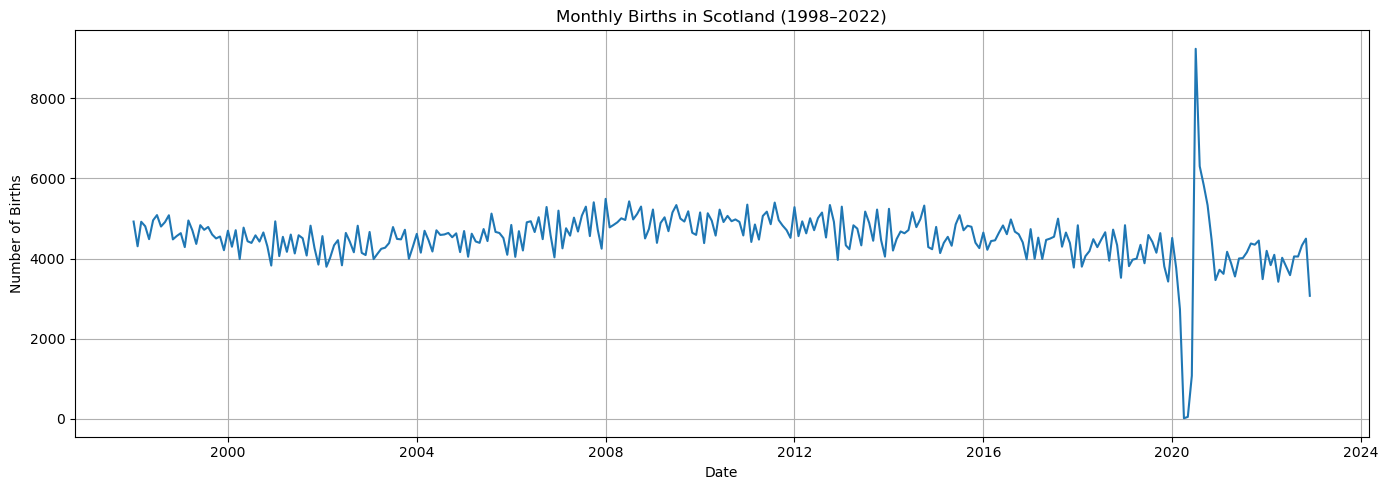

In [72]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='Date', y='Births')
plt.title("Monthly Births in Scotland (1998–2022)")
plt.xlabel("Date")
plt.ylabel("Number of Births")
plt.grid(True)
plt.tight_layout()
plt.show()

**Seasonality – Average Monthly Births Across Years**

In [ ]:
df.set_index('Date', inplace=True)

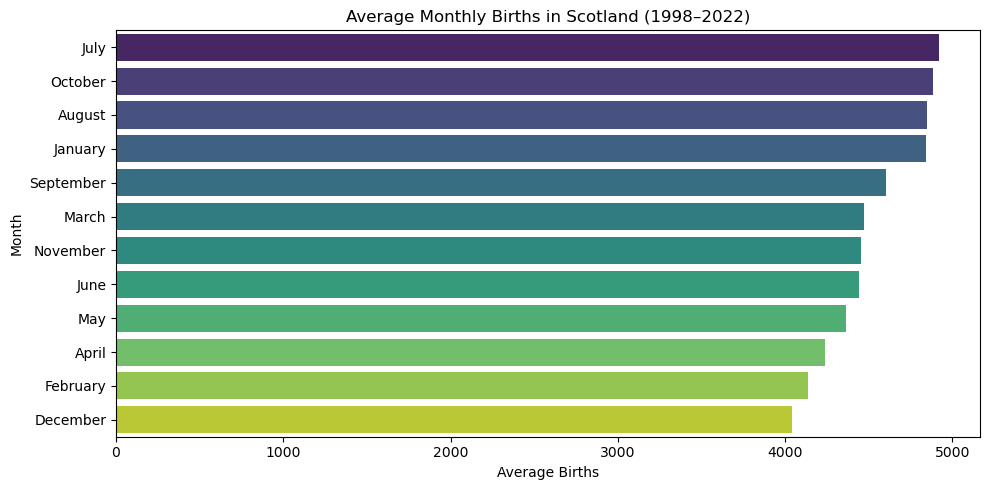

In [87]:
df['Month_Name'] = df.index.month_name()

# Calculate average births per month
monthly_avg = df.groupby('Month_Name')['Births'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'])

monthly_avg_sorted = monthly_avg.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(y=monthly_avg_sorted.index, x=monthly_avg_sorted.values, palette='viridis', orient='h')
plt.title("Average Monthly Births in Scotland (1998–2022)")
plt.xlabel("Average Births")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

#### Step 3A: Add Date-Based Features

In [18]:
#We'll extract additional features to help models learn patterns more effectively.
df['Year'] = df.index.year
df['Month_Num'] = df.index.month
df['Quarter'] = df.index.quarter
df['Is_Mid_Year'] = df.index.month.isin([6, 7]).astype(int)

# Add lag features
# (Lagged values help time series models predict based on recent history)
df['Births_lag1'] = df['Births'].shift(1)   # Previous month
df['Births_lag12'] = df['Births'].shift(12) # Same month last year

df[['Births', 'Births_lag1', 'Births_lag12']].head(15)
#(Births_lag1 correctly shows the previous month’s births
#(Births_lag12 correctly shows same month from last year (starting from Jan 1999))


,Births,Births_lag1,Births_lag12
Date,,,
1998-01-01,4924,NaN,NaN
1998-02-01,4308,4924.0,NaN
1998-03-01,4919,4308.0,NaN
1998-04-01,4807,4919.0,NaN
1998-05-01,4485,4807.0,NaN
1998-06-01,4956,4485.0,NaN
1998-07-01,5085,4956.0,NaN
1998-08-01,4800,5085.0,NaN
1998-09-01,4911,4800.0,NaN


#### Baseline models: Arima/sarima

In [19]:
# Split into training and testing sets
train = df[:'2020']
test = df['2021':]

print("Training shape:", train.shape)
print("Testing shape:", test.shape)


Training shape: (276, 10)
Testing shape: (24, 10)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


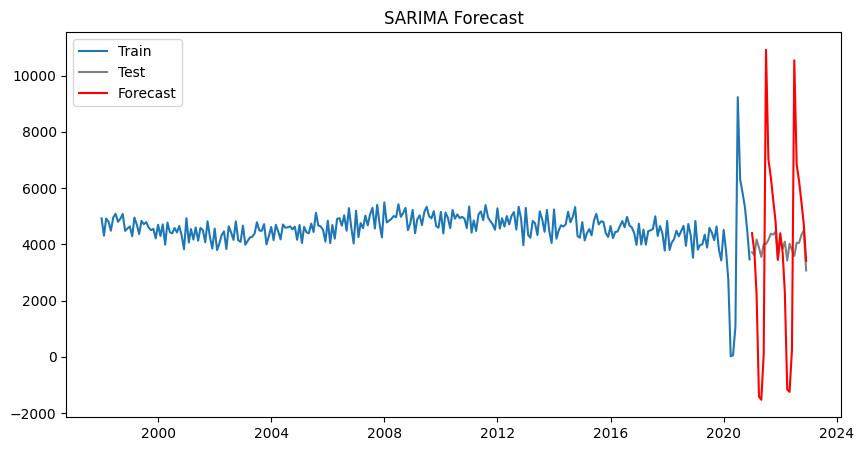

In [20]:
import statsmodels.api as sm

# Fit SARIMA: (p,d,q)(P,D,Q,s)
model = sm.tsa.SARIMAX(train['Births'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results = model.fit()

# Forecast
forecast = results.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Plot
plt.figure(figsize=(10,5))
plt.plot(train['Births'], label='Train')
plt.plot(test['Births'], label='Test', color='gray')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['Births'], forecast)
rmse = np.sqrt(mean_squared_error(test['Births'], forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 2486.99
RMSE: 3306.28


#### XGboost:

In [22]:
df_model = df.copy()
df_model['Date'] = pd.to_datetime(df_model['Year'].astype(str) + '-' + df_model['Month'].astype(str) + '-01')
df_model.set_index('Date', inplace=True)
df_model['Month'] = df_model.index.month
# df_model['Month'] = pd.to_datetime(df_model['Month'], format='%B').dt.month
# Confirm all features are numeric
print(df_model.dtypes)


Year              int32
Month             int32
NHS_Board        object
Births            int64
Month_Name       object
Month_Num         int32
Quarter           int32
Is_Mid_Year       int64
Births_lag1     float64
Births_lag12    float64
dtype: object


In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define features and target
features = ['Births_lag1', 'Births_lag12', 'Year', 'Month']
target = 'Births'

# Split into train/test
X = df_model[features]
y = df_model[target]

X_train = X[:'2020']
X_test = X['2021':]
y_train = y[:'2020']
y_test = y['2021':]

# Fit XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")


XGBoost MAE: 750.08
XGBoost RMSE: 1065.45


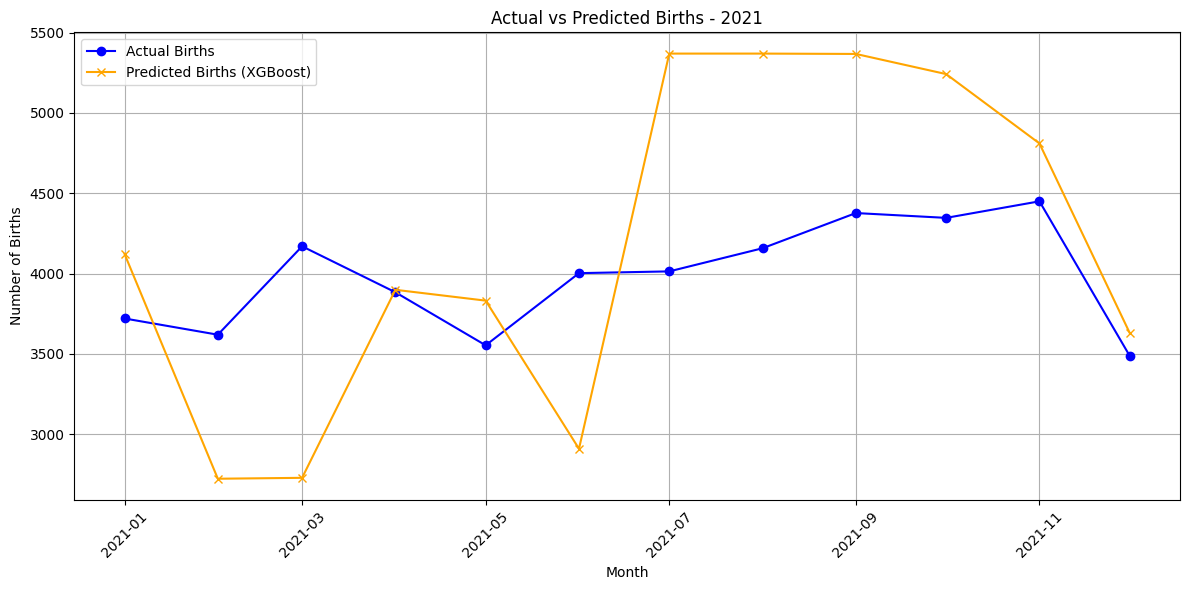

In [24]:
import matplotlib.pyplot as plt

# Filter 2021 data
df_2021 = df_model[df_model.index.year == 2021].copy()
X_2021 = df_2021[['Births_lag1', 'Births_lag12', 'Year', 'Month']]

# Predict using the trained XGBoost model
y_pred_2021 = model_xgb.predict(X_2021)

# Actual values
y_actual_2021 = df_2021['Births']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_2021.index, y_actual_2021, label='Actual Births', marker='o', color='blue')
plt.plot(df_2021.index, y_pred_2021, label='Predicted Births (XGBoost)', marker='x', color='orange')
plt.title('Actual vs Predicted Births - 2021')
plt.xlabel('Month')
plt.ylabel('Number of Births')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
!pip install tensorflow

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Sample synthetic data (replace this with your real series like df['Births'])
series = df['Births']    # e.g., birth counts

# Parameters
window_size = 12
horizon = 3

# Initialize dataset
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_size, horizon):
        self.series = torch.tensor(series.values, dtype=torch.float32)
        self.window_size = window_size
        self.horizon = horizon

    def __len__(self):
        return len(self.series) - self.window_size - self.horizon + 1

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size].unsqueeze(1)  # (window_size, 1)
        y = self.series[idx+self.window_size:idx+self.window_size+self.horizon]
        return x, y
dataset = TimeSeriesDataset(series, window_size=window_size, horizon=horizon)

# Create DataLoader
loader = DataLoader(dataset, batch_size=4, shuffle=False)

# Fetch and show the first batch
for batch_x, batch_y in loader:
    print("Input (X) shape:", batch_x.shape)     # (batch_size, window_size, 1)
    print("Target (Y) shape:", batch_y.shape)     # (batch_size, horizon)
    print("Sample input:\n", batch_x[0].squeeze().numpy())
    print("Sample target:\n", batch_y[0].numpy())
    break


Input (X) shape: torch.Size([4, 12, 1])
Target (Y) shape: torch.Size([4, 3])
Sample input:
 [4924. 4308. 4919. 4807. 4485. 4956. 5085. 4800. 4911. 5081. 4479. 4564.]
Sample target:
 [4635. 4287. 4951.]


In [27]:
# lstm model
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import pandas as pd


series = df['Births']

# Dataset class (same as before)
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, window_size, horizon):
        self.series = torch.tensor(series.values, dtype=torch.float32)
        self.window_size = window_size
        self.horizon = horizon

    def __len__(self):
        return len(self.series) - self.window_size - self.horizon + 1

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size].unsqueeze(1)  # (window_size, 1)
        y = self.series[idx+self.window_size:idx+self.window_size+self.horizon]
        return x, y

# LSTM Model class
class LSTMForecast(nn.Module):
    def __init__(self, hidden_size, num_layers=2, dropout=0.3, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# Parameters
window_size = 12
horizon = 1  # we'll test one-step prediction
hidden_size = 64

# Prepare dataset
dataset = TimeSeriesDataset(series, window_size=window_size, horizon=horizon)
loader = DataLoader(dataset, batch_size=4)

# Initialize model
model = LSTMForecast(hidden_size=hidden_size, bidirectional=False)

# Test a forward pass
for x_batch, y_batch in loader:
    output = model(x_batch)  # [batch_size, 1]
    print("Input shape:", x_batch.shape)      # e.g., [4, 12, 1]
    print("Output shape:", output.shape)      # e.g., [4, 1]
    print("Predictions:\n", output.detach().numpy())
    break


Input shape: torch.Size([4, 12, 1])
Output shape: torch.Size([4, 1])
Predictions:
 [[0.21057393]
 [0.25269037]
 [0.24517266]
 [0.24315147]]


Epoch 1/20, Loss: 20783596.0000
Epoch 2/20, Loss: 20748137.0000
Epoch 3/20, Loss: 20718243.2222
Epoch 4/20, Loss: 20689890.6667
Epoch 5/20, Loss: 20663390.0000
Epoch 6/20, Loss: 20638836.5556
Epoch 7/20, Loss: 20615097.4444
Epoch 8/20, Loss: 20591993.2222
Epoch 9/20, Loss: 20569316.2222
Epoch 10/20, Loss: 20546864.8889
Epoch 11/20, Loss: 20524668.8889
Epoch 12/20, Loss: 20502672.8889
Epoch 13/20, Loss: 20480757.1111
Epoch 14/20, Loss: 20459094.2222
Epoch 15/20, Loss: 20437437.2222
Epoch 16/20, Loss: 20415895.6667
Epoch 17/20, Loss: 20394419.1111
Epoch 18/20, Loss: 20373140.0000
Epoch 19/20, Loss: 20351760.3333
Epoch 20/20, Loss: 20330548.7778

Next Month Birth Forecast: 54.14


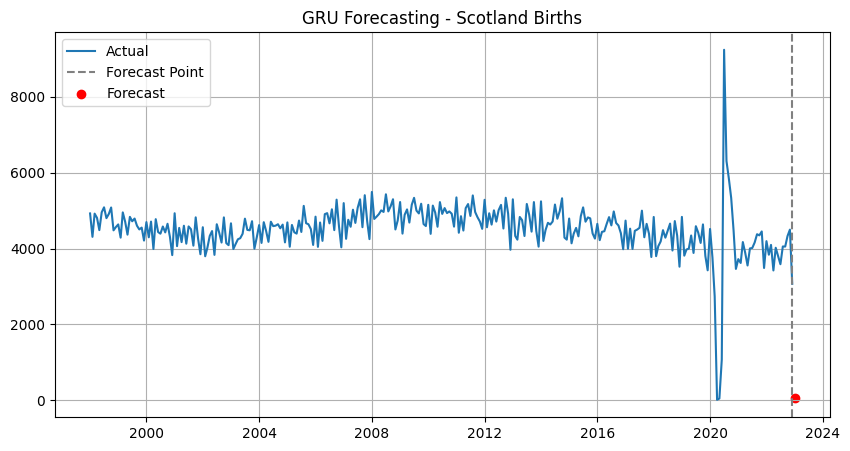

In [29]:
# Gru model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Dataset Definition
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size, horizon):
        self.series = torch.tensor(series.values, dtype=torch.float32)
        self.window_size = window_size
        self.horizon = horizon

    def __len__(self):
        return len(self.series) - self.window_size - self.horizon + 1

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size].unsqueeze(1)  # shape: (window_size, 1)
        y = self.series[idx+self.window_size:idx+self.window_size+self.horizon]
        return x, y

# Step 2: GRU Model Definition
class GRUForecast(nn.Module):
    def __init__(self, hidden_size=64, num_layers=2, dropout=0.3, bidirectional=True):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take last time step
        return self.fc(out)

# Step 3: Load Your Dataset
# df = pd.read_csv("scotland_births.csv", parse_dates=["Date"], index_col="Date")
series = df["Births"]

# Step 4: Prepare Dataset and DataLoader
window_size = 12
horizon = 1
dataset = TimeSeriesDataset(series, window_size, horizon)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 5: Initialize Model, Optimizer, Loss
model = GRUForecast(hidden_size=64, num_layers=2, dropout=0.3, bidirectional=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Step 6: Train the Model
epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = loss_fn(y_pred, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.4f}")

# Step 7: Forecast Next Month
model.eval()
with torch.no_grad():
    last_window = torch.tensor(series.values[-window_size:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    forecast = model(last_window).item()
    print(f"\nNext Month Birth Forecast: {forecast:.2f}")

# Step 8: Optional - Plot Actual vs Forecast
plt.figure(figsize=(10,5))
plt.plot(series, label="Actual")
plt.axvline(x=series.index[-1], color='gray', linestyle='--', label="Forecast Point")
plt.scatter(series.index[-1] + pd.DateOffset(months=1), forecast, color='red', label="Forecast")
plt.legend()
plt.title("GRU Forecasting - Scotland Births")
plt.grid(True)
plt.show()


Epoch 1/20, Loss: 5272456.6858
Epoch 2/20, Loss: 1147206.3420
Epoch 3/20, Loss: 824216.3741
Epoch 4/20, Loss: 704166.5720
Epoch 5/20, Loss: 600242.4453
Epoch 6/20, Loss: 615594.9514
Epoch 7/20, Loss: 552121.7622
Epoch 8/20, Loss: 542625.2300
Epoch 9/20, Loss: 480461.0304
Epoch 10/20, Loss: 429298.3655
Epoch 11/20, Loss: 444290.1042
Epoch 12/20, Loss: 461022.1836
Epoch 13/20, Loss: 443804.5616
Epoch 14/20, Loss: 457058.7005
Epoch 15/20, Loss: 399324.1988
Epoch 16/20, Loss: 433540.0378
Epoch 17/20, Loss: 418797.3125
Epoch 18/20, Loss: 400394.5582
Epoch 19/20, Loss: 376744.1827
Epoch 20/20, Loss: 338676.1753

Next Month Birth Forecast (TCN): 3194.68


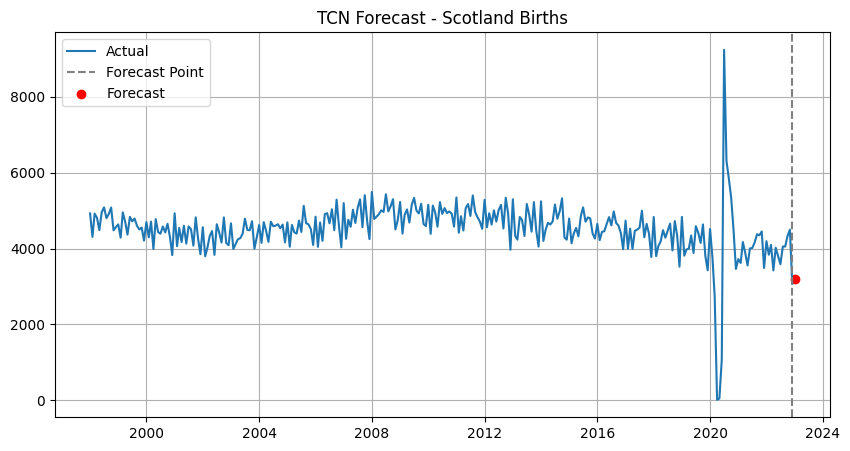

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: TimeSeries Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size, horizon):
        self.series = torch.tensor(series.values, dtype=torch.float32)
        self.window_size = window_size
        self.horizon = horizon

    def __len__(self):
        return len(self.series) - self.window_size - self.horizon + 1

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size].unsqueeze(0)  # shape: (1, window)
        y = self.series[idx+self.window_size:idx+self.window_size+self.horizon]
        return x, y

# Step 2: TCN Residual Block
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]  # causal cropping

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# Step 3: TCN Model
class TCNForecast(nn.Module):
    def __init__(self, input_channels=1, num_channels=[32, 64, 64], kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_channels if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation=dilation_size, padding=padding, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        out = self.network(x)  # shape: (batch, channels, seq_len)
        out = out[:, :, -1]    # last time step
        return self.fc(out)    # output shape: (batch, 1)

# Step 4: Load Data
# df = pd.read_csv("scotland_births.csv", parse_dates=["Date"], index_col="Date")
series = df["Births"]

# Step 5: Dataset & DataLoader
window_size = 12
horizon = 1
dataset = TimeSeriesDataset(series, window_size, horizon)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 6: Model, Loss, Optimizer
model = TCNForecast(input_channels=1, num_channels=[32, 64, 64], kernel_size=3, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Step 7: Train the TCN
epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = loss_fn(y_pred, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.4f}")

# Step 8: Forecast Next Month
model.eval()
with torch.no_grad():
    last_window = torch.tensor(series.values[-window_size:], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    forecast = model(last_window).item()
    print(f"\nNext Month Birth Forecast (TCN): {forecast:.2f}")

# Step 9: Plot Result
plt.figure(figsize=(10,5))
plt.plot(series, label="Actual")
plt.axvline(x=series.index[-1], color='gray', linestyle='--', label="Forecast Point")
plt.scatter(series.index[-1] + pd.DateOffset(months=1), forecast, color='red', label="Forecast")
plt.legend()
plt.title("TCN Forecast - Scotland Births")
plt.grid(True)
plt.show()


In [31]:
# Time series transformer model
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)   # even indices
        pe[:, 1::2] = torch.cos(position * div_term)   # odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # match sequence length
        return x

# Transformer Model
class TransformerForecast(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, output_horizon=1):
        super().__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, output_horizon)

    def forward(self, x):
        # x: (batch, seq_len, 1)
        x = self.input_projection(x)  # -> (batch, seq_len, d_model)
        x = self.positional_encoding(x)  # add positional encoding
        x = self.transformer_encoder(x)  # -> (batch, seq_len, d_model)
        x = x[:, -1, :]  # use the last time step
        return self.output_layer(x)  # -> (batch, output_horizon)


model = TransformerForecast(input_size=1, d_model=64, nhead=4, num_layers=2)
x_sample = torch.randn(32, 12, 1)  # batch_size=32, sequence_length=12
y_pred = model(x_sample)
print(y_pred.shape)

torch.Size([32, 1])


In [32]:
# training strategy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Synthetic Sample Data (Replace this with your real birth data)
np.random.seed(42)
birth_data = df['Births'].values  # Monthly birth data for 20 years

# Hyperparameters
SEQ_LEN = 12
HIDDEN_SIZE = 64
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 100
PATIENCE = 10
AUX_DIFF_WEIGHT = 0.2

# Dataset preparation
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i + seq_len]
        y = data[i + seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(birth_data, SEQ_LEN)
X = torch.tensor(X).float().unsqueeze(-1)  # shape: [samples, seq_len, 1]
y = torch.tensor(y).float().unsqueeze(-1)  # shape: [samples, 1]

# Train/val split
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

# GRU Forecasting Model
class GRUForecast(nn.Module):
    def __init__(self, hidden_size, num_layers=2, dropout=0.3, bidirectional=True):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

# Model, Loss, Optimizer
model = GRUForecast(hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT, bidirectional=BIDIRECTIONAL)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Training Loop with Early Stopping and Auxiliary Loss
best_loss = float('inf')
wait = 0

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)

        # Auxiliary loss on trend change (1st difference)
        if AUX_DIFF_WEIGHT > 0:
            diffs = xb[:, 1:, 0] - xb[:, :-1, 0]  # shape [batch, seq_len-1]
            trend_loss = criterion(diffs[:, -1:], yb - xb[:, -1, 0].unsqueeze(-1))
            loss += AUX_DIFF_WEIGHT * trend_loss

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            y_pred = model(xb)
            val_loss = criterion(y_pred, yb)
            val_losses.append(val_loss.item())

    val_mean = np.mean(val_losses)
    print(f"Epoch {epoch+1:03d} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_mean:.4f}")
    scheduler.step(val_mean)

    if val_mean < best_loss:
        best_loss = val_mean
        torch.save(model.state_dict(), "best_gru_model.pt")
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

# # Load best model and predict next month
model.load_state_dict(torch.load("best_gru_model.pt"))
model.eval()
with torch.no_grad():
    last_seq = torch.tensor(birth_data[-SEQ_LEN:]).float().unsqueeze(0).unsqueeze(-1)  # shape: [1, seq_len, 1]
    next_month = model(last_seq).item()
    print(f"\n📈 Next Month Birth Forecast: {next_month:.2f}")



Epoch 001 | Train Loss: 21708472.5333 | Val Loss: 17530980.0000
Epoch 002 | Train Loss: 21681535.6000 | Val Loss: 17505954.2500
Epoch 003 | Train Loss: 21698257.3333 | Val Loss: 17482946.5000
Epoch 004 | Train Loss: 21581490.6667 | Val Loss: 17461094.5000
Epoch 005 | Train Loss: 21642135.7333 | Val Loss: 17440793.2500
Epoch 006 | Train Loss: 21632278.4000 | Val Loss: 17421622.5000
Epoch 007 | Train Loss: 21604247.3333 | Val Loss: 17403292.0000
Epoch 008 | Train Loss: 21636412.2667 | Val Loss: 17385502.2500
Epoch 009 | Train Loss: 21551557.2000 | Val Loss: 17368060.7500
Epoch 010 | Train Loss: 21541353.0667 | Val Loss: 17350915.0000
Epoch 011 | Train Loss: 21453928.6667 | Val Loss: 17333977.2500
Epoch 012 | Train Loss: 21546059.7333 | Val Loss: 17317259.7500
Epoch 013 | Train Loss: 21415419.2000 | Val Loss: 17300647.2500
Epoch 014 | Train Loss: 21426184.5333 | Val Loss: 17284195.5000
Epoch 015 | Train Loss: 21386157.8667 | Val Loss: 17267825.5000
Epoch 016 | Train Loss: 21384219.8667 | 

In [33]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import itertools
import random

# --- 1. Dataset ---
class BirthDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(-1)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], self.data[idx+self.seq_length])

# --- 2. GRU Model ---
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# --- 3. Training Function ---
def train_model(model, train_loader, val_loader, epochs, lr, patience, aux_diff_weight=0.2, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)

    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch).squeeze()
            loss = criterion(pred, y_batch.squeeze())

            # Auxiliary loss on 1st-order differences
            diff_true = y_batch[:, 0] - X_batch[:, -1, 0]
            diff_pred = pred - X_batch[:, -1, 0]
            loss += aux_diff_weight * criterion(diff_pred, diff_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch).squeeze()
                val_loss = criterion(pred, y_batch.squeeze())
                val_losses.append(val_loss.item())
            mean_val_loss = np.mean(val_losses)

        if verbose:
            print(f"Epoch {epoch+1}: val_loss = {mean_val_loss:.4f}")

        # Early Stopping
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                if verbose:
                    print("Early stopping.")
                break

    return best_loss

# --- 4. Hyperparameter Tuning Function ---
def run_training(hidden_size, num_layers, lr, seq_length, data):
    dataset = BirthDataset(data, seq_length)
    train_size = int(len(dataset) * 0.8)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    model = GRUModel(hidden_size=hidden_size, num_layers=num_layers)
    val_loss = train_model(model, train_loader, val_loader, epochs=30, lr=lr, patience=5, aux_diff_weight=0.2, verbose=False)
    return val_loss

# --- 5. Main Hyperparameter Grid Search ---
if __name__ == "__main__":
    # Load or replace this with real data
    np.random.seed(42)
    birth_data = df['Births'].values

    # Hyperparameter Grid
    hidden_sizes = [32, 64]
    num_layers_list = [1, 2]
    learning_rates = [1e-3, 5e-4]
    seq_lengths = [6, 12]

    param_grid = list(itertools.product(hidden_sizes, num_layers_list, learning_rates, seq_lengths))

    best_loss = float('inf')
    best_params = None

    for hidden_size, num_layers, lr, seq_length in param_grid:
        print(f"🔍 Trying: hidden_size={hidden_size}, layers={num_layers}, lr={lr}, seq_len={seq_length}")
        loss = run_training(hidden_size, num_layers, lr, seq_length, birth_data)
        print(f"→ Validation Loss: {loss:.4f}")

        if loss < best_loss:
            best_loss = loss
            best_params = (hidden_size, num_layers, lr, seq_length)
            print(f"✅ New Best Loss: {best_loss:.4f} with params {best_params}")

    print("\n🏁 Best Hyperparameters:", best_params, "with validation loss:", best_loss)


🔍 Trying: hidden_size=32, layers=1, lr=0.001, seq_len=6
→ Validation Loss: 20241351.0000
✅ New Best Loss: 20241351.0000 with params (32, 1, 0.001, 6)
🔍 Trying: hidden_size=32, layers=1, lr=0.001, seq_len=12
→ Validation Loss: 21090856.0000
🔍 Trying: hidden_size=32, layers=1, lr=0.0005, seq_len=6
→ Validation Loss: 19817229.5000
✅ New Best Loss: 19817229.5000 with params (32, 1, 0.0005, 6)
🔍 Trying: hidden_size=32, layers=1, lr=0.0005, seq_len=12
→ Validation Loss: 21160882.5000
🔍 Trying: hidden_size=32, layers=2, lr=0.001, seq_len=6
→ Validation Loss: 22106846.5000
🔍 Trying: hidden_size=32, layers=2, lr=0.001, seq_len=12
→ Validation Loss: 21039068.5000
🔍 Trying: hidden_size=32, layers=2, lr=0.0005, seq_len=6
→ Validation Loss: 19982100.0000
🔍 Trying: hidden_size=32, layers=2, lr=0.0005, seq_len=12
→ Validation Loss: 20459496.0000
🔍 Trying: hidden_size=64, layers=1, lr=0.001, seq_len=6
→ Validation Loss: 21094469.0000
🔍 Trying: hidden_size=64, layers=1, lr=0.001, seq_len=12
→ Validatio